# RGI-07: Region 12 (Caucasus and Middle East)

F. Maussion & Francesc Roura Adserias & S. Galos, June 2021

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from utils import mkdir

## Files and storage paths

In [2]:
# Region of interest 
reg = 12

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '12_rgi60_CaucasusMiddleEast.zip')

In [3]:
# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
toprint = []
for subid in shp.subm_id.unique():
    s_loc = shp.loc[shp.subm_id == subid]
    s = ''
    for c in ['subm_id', 'analysts', 'src_date']:
        toprint = s_loc[c].unique()
        if c != 'src_date':
            s += ' ' + (str(toprint[0]))
        else:
            for d in toprint:
                s += ' ' + d[:4]
    print(s)

 76.0 Nosenko, Gennadi (Gennady) 2004
 79.0 Nosenko, Gennadi (Gennady) 2004
 81.0 Nosenko, Gennadi (Gennady) 2004
 83.0 Nosenko, Gennadi (Gennady) 2004
 87.0 Nosenko, Gennadi (Gennady) 2004
 327.0 Khromova, Tatyana 2001
 341.0 Seliverstov, Yriy 2000
 423.0 Nosenko, Gennadi (Gennady) 2004
 424.0 Nosenko, Gennadi (Gennady) 1999
 425.0 Khromova, Tatyana 1999
 426.0 Nosenko, Gennadi (Gennady) 1999
 427.0 Nosenko, Gennadi (Gennady) 2001
 428.0 Nosenko, Gennadi (Gennady) 2004
 429.0 Nosenko, Gennadi (Gennady) 2004
 588.0 Ashkan, Farokhnia; Karimi, Neamat; Sara, Sheshangosht 2011
 642.0 Tielidze, Levan 2014 2013 2014 2014 2011 2016
 643.0 Tielidze, Levan 1987 1985 1986 1986 1986 1987
 644.0 Tielidze, Levan 1960
 662.0 Sarikaya, Mehmet Akif 2008 2006 2006 2004 2008 2009 2011
 724.0 Tielidze, Levan 1999 2000 2000 2000 1999 2002


Notes based on inidivual submission evaluations: 
- subm 76 to 429 are all in Caucasus (we don't use them because now have subm 724 there)
- subm 588 is Iran (looks like this was what was used for RGI6)
- subm 662 is Turkey (looks like this was what was used for RGI6)

In [6]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', 'rgi12_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi12_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), 'rgi12_inventories']))

### Apply selection criteria to create the RGI7 data subset

In [7]:
# for Caucasus we use 'subm_id' 724 by analyst 'Tielidze, Levan' which corresponds to the best and closest to 2000 
RGI_ss_caucasus = shp.loc[shp['subm_id'] == 724].copy()
len(RGI_ss_caucasus)

2185

In [8]:
# for Middle East / Iran: 'subm_id' 588
RGI_ss_middle_east = shp.loc[shp['subm_id'] == 588].copy()
len(RGI_ss_middle_east)

484

In [9]:
# for Turkey: 'subm_id' 662
RGI_ss_Turkey = shp.loc[shp['subm_id'] == 662].copy()
len(RGI_ss_Turkey)

51

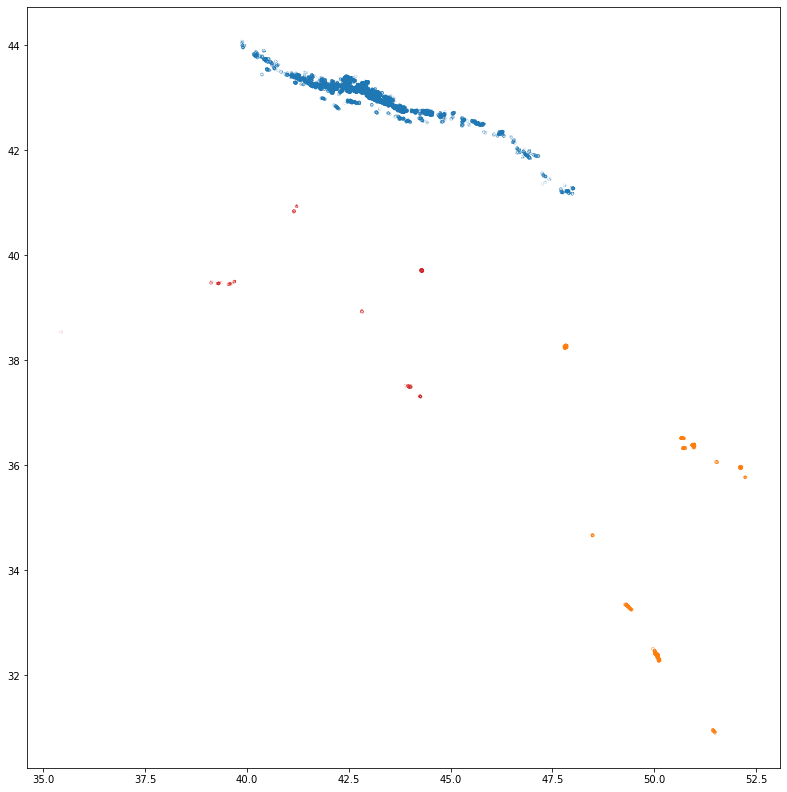

In [10]:
f, ax = plt.subplots(figsize=(14, 14))
RGI_ss_caucasus.plot(ax=ax, edgecolor='C0', linewidth=3)
RGI_ss_middle_east.plot(ax=ax, edgecolor='C1', linewidth=3)
RGI_ss_Turkey.plot(ax=ax, edgecolor='C3', linewidth=3);

In [11]:
# Add a new attribute usefull for later comparisons
RGI_ss_caucasus['changed_from_rgi6'] = True
RGI_ss_middle_east['changed_from_rgi6'] = False
RGI_ss_Turkey['changed_from_rgi6'] = False

In [12]:
# combine the three geodataframes
RGI_ss = pd.concat([RGI_ss_caucasus, RGI_ss_middle_east, RGI_ss_Turkey])

## Write out and tar 

In [13]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...


/tmp/ipykernel_27253/651191772.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')


Taring...
RGI12/
RGI12/RGI12.cpg
RGI12/RGI12.dbf
RGI12/RGI12.prj
RGI12/RGI12.shp
RGI12/RGI12.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI12.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI12'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here RGI6) to enable comparison

In [14]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

## Compare new RGI7-file to RGI6

### Number of elements (differences do not necessarily depict major problems)

In [15]:
print('Number of glaciers in new RGI:', len(RGI_ss))
print('Number of glaciers in RGI6:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI: 2720
Number of glaciers in RGI6: 1888
Difference: 832


### How many nominal glaciers were there in RGI06-R12?

In [16]:
len(ref_odf.loc[ref_odf.Status == 2])

339

### Total area

In [17]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [18]:
# print and compare area values
Area_RGI = RGI_ss['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = ref_odf['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 1433.1047449127695
Area RGI6 [km²]: 1306.999710204219
Area difference [km²]: 126.10503470855065


### Here starts the comparison `RGI7a` with the original `Levan` dataset:  

The data is downloaded from https://zenodo.org/record/5116329#.YXqvaL9Byit

Download: https://zenodo.org/record/5116329/files/CAUCASUS_GLACIERS_2000_2020_Tielidze%20et%20al.%202021.zip?download=1

In [19]:
import urllib
import urllib.request
from urllib.request import urlopen

# download
lev_url = "https://zenodo.org/record/5116329/files/CAUCASUS_GLACIERS_2000_2020_Tielidze%20et%20al.%202021.zip?download=1"
levan_file =  os.path.join(data_dir, 'l0_support_data', 'levan_2000.zip')
urllib.request.urlretrieve(lev_url, filename=levan_file)

('../../rgi7_data/l0_support_data/levan_2000.zip',
 <http.client.HTTPMessage at 0x7f4185b1b520>)

In [42]:
fnames = []
with zipfile.ZipFile(levan_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename and f.filename.endswith('2000.shp'):
            print(f.filename)
            fnames.append(f.filename)

CAUCASUS_GLACIERS_2000_2020_Tielidze et al. 2021/CAU_GLAC_2000/CAU_GLAC_AZER_2000.shp
CAUCASUS_GLACIERS_2000_2020_Tielidze et al. 2021/CAU_GLAC_2000/CAU_GLAC_GEO_2000.shp
CAUCASUS_GLACIERS_2000_2020_Tielidze et al. 2021/CAU_GLAC_2000/CAU_GLAC_RUS_2000.shp


In [21]:
# load levan data
ref_df = []
for fname in fnames:
    ref_df.append(gpd.read_file('zip://' + levan_file + '/' + fname))
ref_df = pd.concat(ref_df)

In [22]:
ref_df = ref_df.to_crs(RGI_ss_caucasus.crs)

We compare to the caucasus RGI only:

In [23]:
print('Number of glaciers in new RGI7 subset:', len(RGI_ss_caucasus))
print('Number of glaciers in reference data (lev):', len(ref_df))
print('Difference:', len(RGI_ss_caucasus)-len(ref_df))

Number of glaciers in new RGI7 subset: 2185
Number of glaciers in reference data (lev): 2186
Difference: -1


In [24]:
# add an area field to RGI_ss and reference data
RGI_ss_caucasus['area'] = RGI_ss_caucasus.to_crs({'proj':'cea'}).area
ref_df['area'] = ref_df.to_crs({'proj':'cea'}).area

In [25]:
# print and compare area values
Area_RGI = RGI_ss_caucasus['area'].sum() * 1e-6
print('Area RGI [km²]:', Area_RGI)
Area_lev = ref_df['area'].sum() * 1e-6
print('Area Ref (lev) [km²]:', Area_lev)
d = (Area_RGI - Area_lev)
print('Area difference [km²]:', d)

Area RGI [km²]: 1381.3214292443179
Area Ref (lev) [km²]: 1381.463208157751
Area difference [km²]: -0.1417789134331997


### Find the missing glacier 

The code below is dirty. 

In [26]:
df_ref = ref_df.copy()
rgi7 = RGI_ss_caucasus.copy()

In [27]:
from utils import haversine
import progressbar
import numpy as np

In [28]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [29]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()
coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

rp = rgi7.representative_point()
coordinates = np.array(list(rp.apply(xy_coord)))
rgi7['CenLon'] = coordinates[:, 0]
rgi7['CenLat'] = coordinates[:, 1]

<AxesSubplot:>

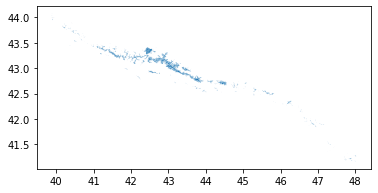

In [30]:
df_ref.plot()

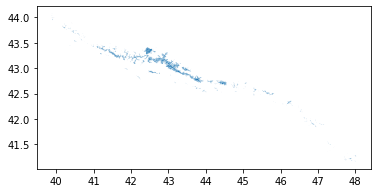

In [31]:
rgi7.plot();

In [32]:
df_ref_orig = df_ref.copy()

In [33]:
# Loop over all RGI7 glaciers and find their equivalent in ref
N_search = 1
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:N_search]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.001):
            found = True
#             df_ref.drop(labels=[s6.name], inplace=True)
            break
    if not found:
        break
#     if len(to_drop) > 1000:
#         df_ref.drop(labels=to_drop, inplace=True)
#         to_drop = []
# df_ref.drop(labels=to_drop, inplace=True)

 36% (803 of 2185) |#######              | Elapsed Time: 0:00:00 ETA:   0:00:00

In [34]:
dist[np.argsort(dist)][0]

1.4811061137531668e-06

In [35]:
s6['area'] / ref_area

0.9533419522029631

In [36]:
f, ax = plt.subplots()
.plot(ax=ax, color='C3');
.plot(ax=ax);

SyntaxError: invalid syntax (3679852505.py, line 2)

In [ ]:
rgi7.iloc[[i]].overlay(df_ref.iloc[[j]], how='difference').plot()

In [ ]:
df_ref.iloc[[np.argsort(dist)[0]]]

In [ ]:
df_ref.iloc[[j]]

In [ ]:
s6['area'], ref_area,

In [ ]:
np.argsort(dist)[:N_search]

In [ ]:
print(len(not_found), len(df_ref))

In [ ]:
not_found.keys()

In [ ]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

In [ ]:
for i, k in enumerate(not_found.keys()):
    ax = rgi7.iloc[[k]].plot(edgecolor='k');
    if  i > 10:
        break

In [ ]:
pb_rgi7